# Medicare Physician and Other Supplier Data (Ophthamologists in CA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Cleaning/Feature Engineering (2)

In [2]:
# Reading the data from 2012 to 2018

data2018 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2018_CA_Ophthalmology.csv')
data2017 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2017_CA_Ophthalmology.csv')
data2016 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2016_CA_Ophthalmology.csv')
data2015 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2015_CA_Ophthalmology.csv')
data2014 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_PUF_CY2014_CA_Ophthalmology.csv')
data2013 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_CY2013_CA_Ophthalmology.csv')
data2013 = data2013.rename(columns={'National Provider Identifier ':'National Provider Identifier'})
data2012 = pd.read_csv('D:\\Anaconda\\Jupyter Directory\\Medicare Fraud Detection\\MedicareData_California_Opthalmology\\Medicare_Provider_Utilization_and_Payment_Data__Physician_and_Other_Supplier_CY2012_CA_Ophthalmology.csv')


In the following, we create a pivoted dataset in which every row represents a provider (denoted by its NPI). **Each entry of this dataset represents either the ratio of the number of services to the number of beneficiaries for a specific HCPCS code in a particular year, or just the number of services for a specific HCPCS code in a particular year.** Also, we add the fraud labels as the last column of this pivoted dataset. 

In [3]:
# Cleaning and pivoting the data (2012-2018)

def rem_comma(s):
    s1 = s.replace(',', '')
    return s1

def clean_pivot(data, period):
    
    data = data.sort_values(by=['National Provider Identifier'])
    
    if period == '2013':
        data['Number of Services'] = data['LINE_SRVC_CNT'].apply(rem_comma)
        data['Number of Medicare Beneficiaries'] = data['BENE_UNIQUE_CNT'].apply(rem_comma)
        data['HCPCS Code'] = data['HCPCS_CODE']
    else: 
        data['Number of Services'] = data['Number of Services'].apply(rem_comma)
        data['Number of Medicare Beneficiaries'] = data['Number of Medicare Beneficiaries'].apply(rem_comma)
        
    data['Number of Services'] = data['Number of Services'].apply(float)
    data['Number of Medicare Beneficiaries'] = data['Number of Medicare Beneficiaries'].apply(float)
    data = data.loc[:, ['National Provider Identifier', 'HCPCS Code', 'Number of Services', 'Number of Medicare Beneficiaries']]

    idx = 0
    while (idx + 1) < data.shape[0]:
        s = data.shape[0]
        NPI = data.iat[idx, 0]
        c = 1
        while idx + c < data.shape[0] and data.iat[idx + c, 0] == NPI:
            if data.iat[idx + c, 1] == data.iat[idx, 1]:
                data.iat[idx, 2] = data.iat[idx, 2] + data.iat[idx + c, 2]
                data.iat[idx, 3] = data.iat[idx, 3] + data.iat[idx + c, 3] # Warning: Some of the beneficiaries received the service in a facility location may be the same as those who received it in a non-facility location. 
                data = data.drop([idx + c])
                data = data.reset_index(drop=True)
                break
            else:
                c += 1
        if s == data.shape[0]:
            idx += 1 
    
    data['Ratio of NoS to NoMB'] = data['Number of Services'] / data['Number of Medicare Beneficiaries']
    data_NoS = data.loc[:, ['National Provider Identifier', 'HCPCS Code', 'Number of Services']]
    data_Ratio = data.loc[:, ['National Provider Identifier', 'HCPCS Code', 'Ratio of NoS to NoMB']]
    
    data_pivoted_NoS = data_NoS.pivot(index='National Provider Identifier', columns='HCPCS Code', values='Number of Services')
    data_pivoted_NoS = data_pivoted_NoS.fillna(0)
    data_pivoted_Ratio = data_Ratio.pivot(index='National Provider Identifier', columns='HCPCS Code', values='Ratio of NoS to NoMB')
    data_pivoted_Ratio = data_pivoted_Ratio.fillna(0)
    
    return data_pivoted_NoS, data_pivoted_Ratio

In [4]:
# 2018 pivoted data

data2018_copy = data2018.copy()
data2018_pivoted_NoS,  data2018_pivoted_Ratio= clean_pivot(data2018_copy, '2018')

# 2017 pivoted data

data2017_copy = data2017.copy()
data2017_pivoted_NoS,  data2017_pivoted_Ratio= clean_pivot(data2017_copy, '2017')

# 2016 pivoted data

data2016_copy = data2016.copy()
data2016_pivoted_NoS,  data2016_pivoted_Ratio= clean_pivot(data2016_copy, '2016')

# 2015 pivoted data

data2015_copy = data2015.copy()
data2015_pivoted_NoS, data2015_pivoted_Ratio = clean_pivot(data2015_copy, '2015')

# 2014 pivoted data

data2014_copy = data2014.copy()
data2014_pivoted_NoS, data2014_pivoted_Ratio = clean_pivot(data2014_copy, '2014')

# 2013 pivoted data

data2013_copy = data2013.copy()
data2013_pivoted_NoS, data2013_pivoted_Ratio = clean_pivot(data2013_copy, '2013')

# 2012 pivoted data

data2012_copy = data2012.copy()
data2012_pivoted_NoS, data2012_pivoted_Ratio = clean_pivot(data2012_copy, '2012')

In [5]:
# Merging the data over different years

HCPCS_pool = set([*data2012_pivoted_NoS.columns, *data2013_pivoted_NoS.columns, *data2014_pivoted_NoS.columns, *data2015_pivoted_NoS.columns,
                  *data2016_pivoted_NoS.columns, *data2017_pivoted_NoS.columns, *data2018_pivoted_NoS.columns])
NPI_pool = set([*data2012_pivoted_NoS.index, *data2013_pivoted_NoS.index, *data2014_pivoted_NoS.index, *data2015_pivoted_NoS.index,
                  *data2016_pivoted_NoS.index, *data2017_pivoted_NoS.index, *data2018_pivoted_NoS.index])

# Merging the NoS data

data_pivoted = [data2012_pivoted_NoS.copy(), data2013_pivoted_NoS.copy(), data2014_pivoted_NoS.copy(), data2015_pivoted_NoS.copy(),
                data2016_pivoted_NoS.copy(), data2017_pivoted_NoS.copy(), data2018_pivoted_NoS.copy()]

for i in range(len(data_pivoted)):
    
    idx_list = set(data_pivoted[i].index)
    diff_idx_list = NPI_pool - idx_list
    for npi in diff_idx_list:
        data_pivoted[i].loc[npi] = 0.0
    
    clmn_list = set(data_pivoted[i].columns)
    diff_clmn_list = HCPCS_pool - clmn_list
    for hcpcs in diff_clmn_list:
        data_pivoted[i][hcpcs] = 0.0
        
    data_pivoted[i] = data_pivoted[i].reindex(sorted(data_pivoted[i].columns), axis=1)
    data_pivoted[i] = data_pivoted[i].sort_index()

index_list = data_pivoted[0].index
columns_list = data_pivoted[0].columns
data_merged = pd.DataFrame(index=index_list)
for hcpcs in columns_list:
    for i in range(len(data_pivoted)):
        year = str(i + 2012)
        column_name = hcpcs + '-' + year
        data_merged[column_name] = data_pivoted[i][hcpcs] 
data_merged_NoS = data_merged.copy()
data_merged_NoS.to_csv(r'D:\Anaconda\Jupyter Directory\Medicare Fraud Detection\MedicareData_California_Opthalmology\data_merged_NoS.csv')

# Merging the Ratio data

data_pivoted = [data2012_pivoted_Ratio.copy(), data2013_pivoted_Ratio.copy(), data2014_pivoted_Ratio.copy(), data2015_pivoted_Ratio.copy(),
                data2016_pivoted_Ratio.copy(), data2017_pivoted_Ratio.copy(), data2018_pivoted_Ratio.copy()]

for i in range(len(data_pivoted)):
    
    idx_list = set(data_pivoted[i].index)
    diff_idx_list = NPI_pool - idx_list
    for npi in diff_idx_list:
        data_pivoted[i].loc[npi] = 0.0
    
    clmn_list = set(data_pivoted[i].columns)
    diff_clmn_list = HCPCS_pool - clmn_list
    for hcpcs in diff_clmn_list:
        data_pivoted[i][hcpcs] = 0.0
        
    data_pivoted[i] = data_pivoted[i].reindex(sorted(data_pivoted[i].columns), axis=1)
    data_pivoted[i] = data_pivoted[i].sort_index()

index_list = data_pivoted[0].index
columns_list = data_pivoted[0].columns
data_merged = pd.DataFrame(index=index_list)
for hcpcs in columns_list:
    for i in range(len(data_pivoted)):
        year = str(i + 2012)
        column_name = hcpcs + '-' + year
        data_merged[column_name] = data_pivoted[i][hcpcs] 
data_merged_Ratio = data_merged.copy()
data_merged_Ratio.to_csv(r'D:\Anaconda\Jupyter Directory\Medicare Fraud Detection\MedicareData_California_Opthalmology\data_merged_Ratio.csv')

In [12]:
# Adding the fraud labels to the merged datasets

data_merged_NoS = pd.read_csv(r'D:\Anaconda\Jupyter Directory\Medicare Fraud Detection\MedicareData_California_Opthalmology\data_merged_NoS.csv', index_col=0)
data_merged_Ratio = pd.read_csv(r'D:\Anaconda\Jupyter Directory\Medicare Fraud Detection\MedicareData_California_Opthalmology\data_merged_Ratio.csv', index_col=0)

fraudulent_npi = [1003816141, 1013010685, 1114913761, 1124131958, 1124150065, 1134232648, 1275626897, 1285622662, 1306023973, 1326230822, 1386989440, 1477573319, 
                  1518046754, 1528054640, 1649316753, 1720096829, 1720123110, 1740210236, 1760566566, 1780609933, 1821273137, 1861470783, 1932270097]

data_merged_NoS_labeled = data_merged_NoS.copy()
data_merged_NoS_labeled['Fraudulent'] = 0.0
for i in range(len(fraudulent_npi)):
    data_merged_NoS_labeled.at[fraudulent_npi[i], 'Fraudulent'] = 1.0
    
data_merged_Ratio_labeled = data_merged_Ratio.copy()
data_merged_Ratio_labeled['Fraudulent'] = 0.0
for i in range(len(fraudulent_npi)):
    data_merged_Ratio_labeled.at[fraudulent_npi[i], 'Fraudulent'] = 1.0

In [17]:
data_merged_NoS_labeled

,00140-2012,00140-2013,00140-2014,00140-2015,00140-2016,00140-2017,00140-2018,00142-2012,00142-2013,00142-2014,...,Q9977-2017,Q9977-2018,V2790-2012,V2790-2013,V2790-2014,V2790-2015,V2790-2016,V2790-2017,V2790-2018,Fraudulent
National Provider Identifier,,,,,,,,,,,,,,,,,,,,,
1003015504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003028580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003056516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003072786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003093774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992804504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992863443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992876155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Further feature engineering:

In [53]:
clmns = list(data_merged_NoS_labeled.columns)
clmns_9 = [hcpcs for hcpcs in clmns if hcpcs[0] == '9' or hcpcs == 'Fraudulent']
data_merged_NoS_9 = data_merged_NoS_labeled.loc[:, clmns_9]

clmns = list(data_merged_Ratio_labeled.columns)
clmns_9 = [hcpcs for hcpcs in clmns if hcpcs[0] == '9' or hcpcs == 'Fraudulent']
data_merged_Ratio_9 = data_merged_Ratio_labeled.loc[:, clmns_9]

In [83]:
X = data_merged_NoS_9.loc[:, data_merged_NoS_9.columns[0:-1]].values

X_compact = np.zeros((X.shape[0], int(X.shape[1] / 7)))
for r in range(X_compact.shape[0]):
    for c in range(X_compact.shape[1]):
         X_compact[r, c] = np.sum(X[r, c * 7 : (c+1) * 7])
            
for c in range(X_compact.shape[1]):
    v = X_compact[:, c]
    m = np.mean(v)
    std = np.std(v)
    X_compact[:, c] = v - m
    if std != 0:
        X_compact[:, c] /= std

feature = np.zeros(X_compact.shape[0])
for r in range(X_compact.shape[0]):
    v = X_compact[r, :]
    feature[r] = np.sum([v > 1])
    
NoS_feature = feature

In [82]:
X = data_merged_Ratio_9.loc[:, data_merged_Ratio_9.columns[0:-1]].values

X_compact = np.zeros((X.shape[0], int(X.shape[1] / 7)))
for r in range(X_compact.shape[0]):
    for c in range(X_compact.shape[1]):
         X_compact[r, c] = np.max(X[r, c * 7 : (c+1) * 7])
            
for c in range(X_compact.shape[1]):
    v = X_compact[:, c]
    m = np.mean(v)
    std = np.std(v)
    X_compact[:, c] = v - m
    if std != 0:
        X_compact[:, c] /= std

feature = np.zeros(X_compact.shape[0])
for r in range(X_compact.shape[0]):
    v = X_compact[r, :]
    feature[r] = np.sum([v > 1])
    
Ratio_feature = feature

<IPython.core.display.Javascript object>


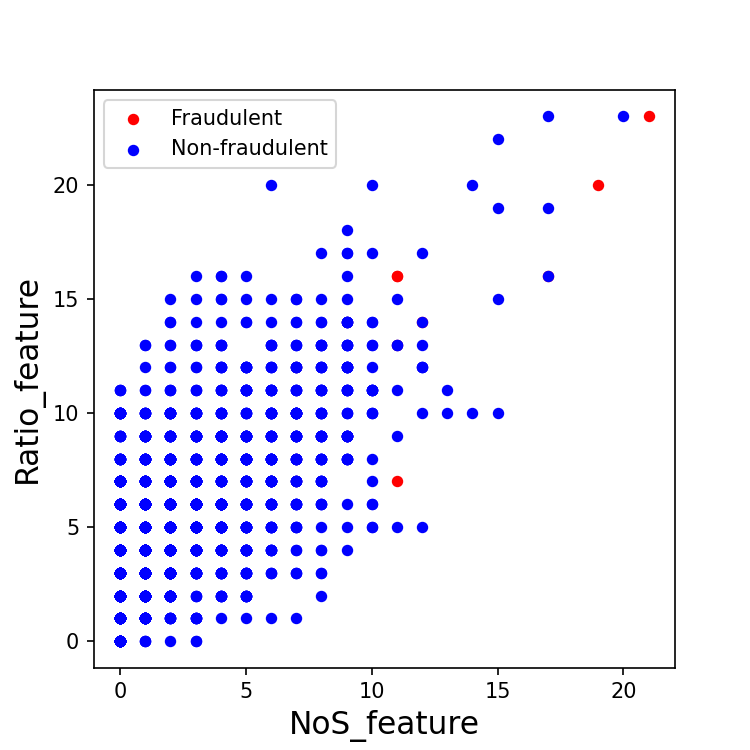

In [84]:
y = data_merged_NoS_labeled.loc[:, 'Fraudulent'].values

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('NoS_feature', fontsize = 15)
ax.set_ylabel('Ratio_feature', fontsize = 15)
#ax.set_title('', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = (y == target)
    ax.scatter(NoS_feature[indicesToKeep], Ratio_feature[indicesToKeep], c = color, s = 20)
ax.legend(['Fraudulent', 'Non-fraudulent'])

In [62]:
def relu(x):
    return max(0, x)

def SU(data): # For data with label
    for clmn in data.columns[0:-1]:
        v = data[clmn]
        m = np.mean(v)
        std = np.std(v)
        data[clmn] = v - m
        #data[clmn] = data[clmn].apply(relu)
        if std != 0:
            data[clmn] /= std
    return data

In [87]:
#clmns = list(data_merged_NoS_labeled.columns)
#clmns_noJ = [hcpcs for hcpcs in clmns if hcpcs[0] != 'J']
#data_merged_NoS_labeled_noJ = data_merged_NoS_labeled.loc[:, clmns_noJ]

#clmns = list(data_merged_Ratio_labeled.columns)
#clmns_noJ = [hcpcs for hcpcs in clmns if hcpcs[0] != 'J']
#data_merged_Ratio_labeled_noJ = data_merged_Ratio_labeled.loc[:, clmns_noJ]

clmns = list(data_merged_NoS_labeled.columns)
clmns_9 = [hcpcs for hcpcs in clmns if hcpcs[0] == '9' or hcpcs == 'Fraudulent']
data_merged_NoS_9 = data_merged_NoS_labeled.loc[:, clmns_9]

clmns = list(data_merged_Ratio_labeled.columns)
clmns_9 = [hcpcs for hcpcs in clmns if hcpcs[0] == '9' or hcpcs == 'Fraudulent']
data_merged_Ratio_9 = data_merged_Ratio_labeled.loc[:, clmns_9]

#clmns = list(data_merged_Ratio_labeled.columns)
#clmns_2012_2013 = [hcpcs for hcpcs in clmns if hcpcs[-1] == '2' or hcpcs[-1] == '3' or hcpcs == 'Fraudulent']
#data_merged_Ratio_2012_2013 = data_merged_Ratio_labeled.loc[:, clmns_2012_2013]

data_NoS_SU = SU(data_merged_NoS_9.copy())
data_Ratio_SU = SU(data_merged_Ratio_9.copy())

In [130]:
def feat_ext(data): # For data with label
    X = data.loc[:, data.columns[0:-1]].values
    feature = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        v = X[i, :]        
        feature[i] = np.sum([v > 5])
    return feature

NoS_feature = feat_ext(data_NoS_SU)
Ratio_feature = feat_ext(data_Ratio_SU)

<IPython.core.display.Javascript object>


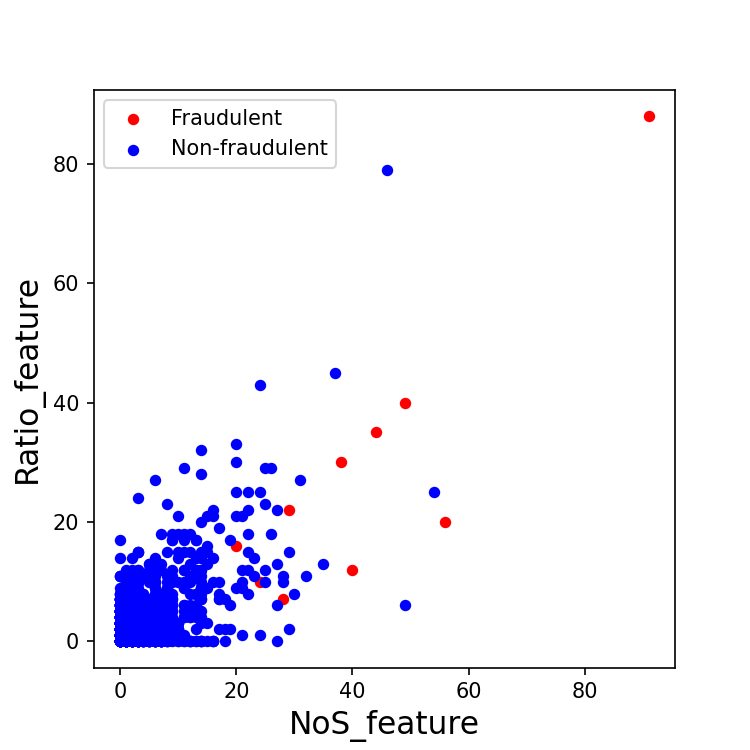

In [131]:
y = data_merged_NoS_labeled.loc[:, 'Fraudulent'].values

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('NoS_feature', fontsize = 15)
ax.set_ylabel('Ratio_feature', fontsize = 15)
#ax.set_title('', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = (y == target)
    ax.scatter(NoS_feature[indicesToKeep], Ratio_feature[indicesToKeep], c = color, s = 20)
ax.legend(['Fraudulent', 'Non-fraudulent'])

In [133]:
for i in range(len(Ratio_feature)):
    if Ratio_feature[i] > 60:
        print(i)
        

7
1591


In [134]:
data_merged_NoS.iloc[1591]

00140-2012    0.0
00140-2013    0.0
00140-2014    0.0
00140-2015    0.0
00140-2016    0.0
             ... 
V2790-2014    0.0
V2790-2015    0.0
V2790-2016    0.0
V2790-2017    0.0
V2790-2018    0.0
Name: 1649316753, Length: 3619, dtype: float64

In [15]:
%matplotlib notebook
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [17]:
X = data_Ratio_SU.loc[:, data_Ratio_SU.columns[0:-1]].values
y = data_Ratio_SU.loc[:, 'Fraudulent'].values
#X = StandardScaler().fit_transform(X)

#### 2-component PCA

<IPython.core.display.Javascript object>


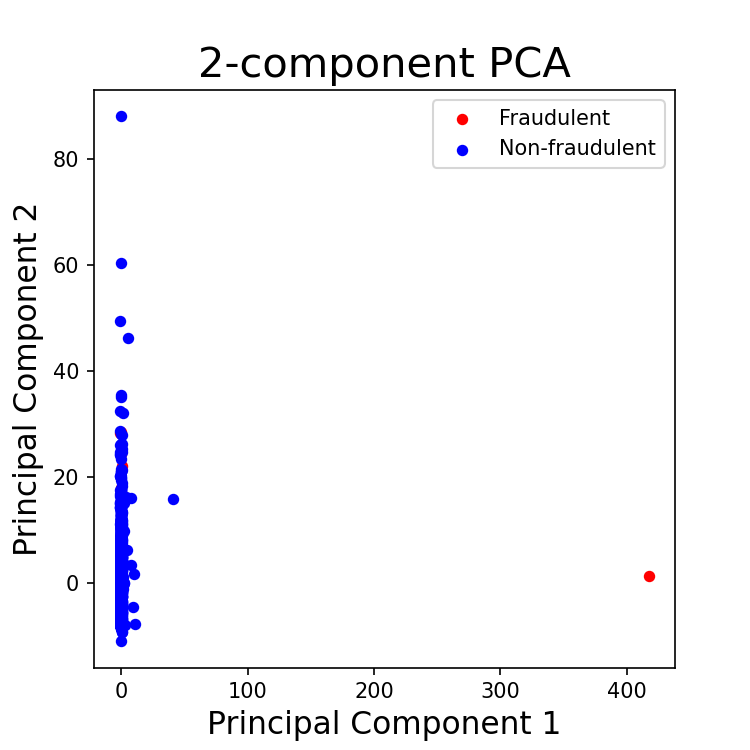

In [18]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
pcdf = pd.DataFrame(data=pcs, columns=['pc1', 'pc2'])
pcdf['Fraudulent'] = data_Ratio_SU['Fraudulent'].values

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2-component PCA', fontsize = 20)
targets = [1.0, 0.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pcdf['Fraudulent'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 20)
ax.legend(['Fraudulent', 'Non-fraudulent'])

In [20]:
data_Ratio_SU.shape

(2483, 2339)